# Performance Analysis of Model

This notebook will guide through my performance analysis of the model.

We'll target a few questions:
- How well does the model perform?
- What assumptions are made?
- What does the model perform better on? What about the poor ones?

## Preparation

As usual, we'll load relevant libraries and ...
- Load our test data
- Load our model

In [1]:
import sys

import pandas as pd

sys.path.append("../opal/data_ppy_sh_to_csv/")
sys.path.append("../")
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl

from opal.score.collaborative_filtering.neu_mf import NeuMF
from opal.score.datamodule import ScoreDataModule

dm = ScoreDataModule(
    ds_yyyy_mm="2022_11", batch_size=16,
    score_bounds=(7.5e5, 1e6),
)

Download Files: 
	- D:/Repositories/PycharmProjects/opal/models/../data/2022_11_01_performance_mania_top_1000.tar.bz2
Derived Files: 
	- D:/Repositories/PycharmProjects/opal/models/../data/2022_11_01_performance_mania_top_1000/___.sql (All SQL Files are extracted)
	- D:/Repositories/PycharmProjects/opal/models/../data/2022_11_01_performance_mania_top_1000/csv/osu_user_stats_mania.csv
	- D:/Repositories/PycharmProjects/opal/models/../data/2022_11_01_performance_mania_top_1000/csv/osu_scores_mania_high.csv
	- D:/Repositories/PycharmProjects/opal/models/../data/2022_11_01_performance_mania_top_1000/csv/osu_beatmap_difficulty.csv
	- D:/Repositories/PycharmProjects/opal/models/../data/2022_11_01_performance_mania_top_1000/csv/osu_beatmaps.csv
Proceeding to Download ...
File exists, and overwrite is false, skipping
Download Files: 
	- D:/Repositories/PycharmProjects/opal/models/../data/2022_11_01_performance_mania_top_1000.tar.bz2
Derived Files: 
	- D:/Repositories/PycharmProjects/opal/model

KeyboardInterrupt: 

In [3]:
net = NeuMF.load_from_checkpoint(
    "2022_11_1000_tiny/tiny/checkpoints/epoch=14-step=13110.ckpt",
    dm=dm
)

In [4]:
# Set to evaluate mode (no gradient update)
net.eval()
trainer = pl.Trainer(accelerator='cpu', limit_predict_batches=16)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
D:\ProgramFiles\Anaconda\envs\opal\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


## Predicting
We'll use our validation data to predict.

In [9]:
%%capture
y = trainer.predict(net, datamodule=dm)
y_preds = []
y_trues = []
for x_uid_real, x_mid_real, y_pred, y_true in y:
    y_preds.append(y_pred)
    y_trues.append(y_true)
y_preds = np.stack(y_preds).flatten()
y_trues = np.stack(y_trues).flatten()

In [29]:
(6976 + 592 * 30/32 + 14 * 20/32 + 1 * 5/32) / (6976 + 592 + 14 + 1 + 3)

0.9939238399683628

In [30]:
# 2193881
import torch
x_uid_real = ["259972/2022", "259972/2021", "259972/2020", "259972/2019", "259972/2018", "259972/2017", "259972/2016", "259972/2015"]
# x_uid_real = ["758406/2022", "758406/2021"] #, "758406/2019", "758406/2018", "758406/2017", "758406/2016", "758406/2015"]
x_mid_real = ["3389406/0"] * len(x_uid_real)

net.predict(x_uid_real, x_mid_real)



array([0.9906539 , 0.98697   , 0.9908846 , 0.98645365, 0.98696697,
       0.9774379 , 0.97705245, 0.9305121 ], dtype=float32)

In [37]:
x = net.scaler_inverse(net(x_uid, x_mid)).squeeze()

# Analysis

We'll firstly do some quick viz to get an intuition of the data

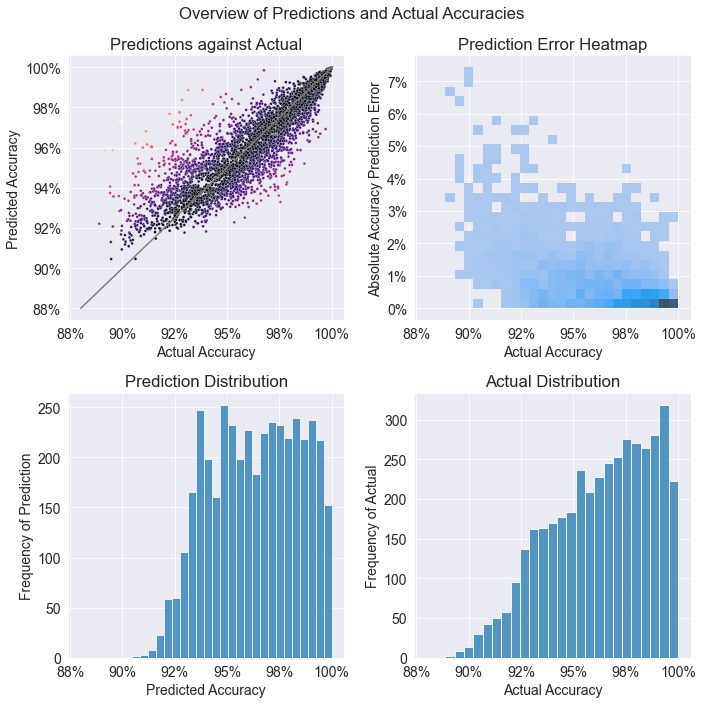

In [10]:
import seaborn as sns
import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10, 10))
plt.suptitle("Overview of Predictions and Actual Accuracies")

ax1 = plt.subplot(221)
sns.lineplot(x=[0.88, 1], y=[0.88, 1], color='gray')
sns.scatterplot(x=y_trues, y=y_preds, s=8, c=np.abs(y_trues - y_preds),
                cmap='magma')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.title("Predictions against Actual")
plt.xlabel("Actual Accuracy")
plt.ylabel("Predicted Accuracy")

ax2 = plt.subplot(222)
ax2.sharex(ax1)
sns.histplot(x=y_trues, y=np.abs(y_preds - y_trues), bins=25)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.title("Prediction Error Heatmap")
plt.xlabel("Actual Accuracy")
plt.ylabel("Absolute Accuracy Prediction Error")

ax3 = plt.subplot(223)
ax3.sharex(ax1)
sns.histplot(x=y_preds, bins=25)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.title("Prediction Distribution")
plt.xlabel("Predicted Accuracy")
plt.ylabel("Frequency of Prediction")

ax4 = plt.subplot(224)
ax4.sharex(ax1)
sns.histplot(x=y_trues, bins=25)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.title("Actual Distribution")
plt.xlabel("Actual Accuracy")
plt.ylabel("Frequency of Actual")
plt.tight_layout()

plt.show()

**Biases Correction**

If you've seen my previous analysis, you'll see that our predictions for lower (actual) accuracies are biased.
This is because our model assumes a normal distribution for our input data, however, it's actually heavily skewed.
Despite the sigmoid correction, it was still insufficient to correct the biases, thus, alternatively, we used a `QuantileTransformer` to force transform data into a normal distribution.

**Score Limiting**

We limited the input to only have scores > 750,000. Thus, accuracies taper around 90.00%.
This may have caused the model to not be able to predict scores beyond 90.00%, however we're not that interested in those predictions.

Despite that, it may prove to be more useful if we included those, so we'll circle back next time.


## Analysis of input

We also have our `DataFrame` of input data, let's take a glance

In [5]:
df = dm.df

In [6]:
df.head()

,difficultyrating,diff_overall,diff_size,version,beatmap_id,filename,user_id,year,score,accuracy,speed,uid,mid,uid_le,mid_le
0,3.39962,8.0,7.0,Hard,192345.0,FamiRockP - Oni Kanojo (Entozer) [Hard].osu,437945.0,2014,795309.0,-1.430494,0.0,437945/2014,192345/0,2521,2118
1,3.39962,8.0,7.0,Hard,192345.0,FamiRockP - Oni Kanojo (Entozer) [Hard].osu,623773.0,2014,931373.0,0.053889,0.0,623773/2014,192345/0,2867,2118
2,3.39962,8.0,7.0,Hard,192345.0,FamiRockP - Oni Kanojo (Entozer) [Hard].osu,1192936.0,2014,761921.0,-2.269374,0.0,1192936/2014,192345/0,629,2118
3,3.39962,8.0,7.0,Hard,192345.0,FamiRockP - Oni Kanojo (Entozer) [Hard].osu,1326008.0,2014,878780.0,-0.999728,0.0,1326008/2014,192345/0,970,2118
4,3.39962,8.0,7.0,Hard,192345.0,FamiRockP - Oni Kanojo (Entozer) [Hard].osu,1517607.0,2014,984948.0,0.550902,0.0,1517607/2014,192345/0,1325,2118


We see 6 columns, the first 2 are `str` columns, for `LabelEncoder` to encode, the result is the last 2.

E.g.

`uid=U/YYYY` means the user, with user id `U`, with the score in year `YYYY`.

`mid=M/S` means the map, with beatmap id `M` with speed of map `S`.
- `S=1`: Double Time
- `S=0`: Normal Time
- `S=-1`: Half Time

Note that our accuracies are quantile transformed.

# Performance of Model

Now, let's figure out how well the model performed on the prediction.

In [12]:
f"The MAE is {np.abs(y_preds - y_trues).mean():.2%} with RMSE {((y_preds - y_trues) ** 2).mean() ** 0.5:.2%}"

'The MAE is 0.81% with RMSE 1.16%'

Sort of tells us that the general error is around 1%, which is acceptable.

Let's find out the errors of each percentage

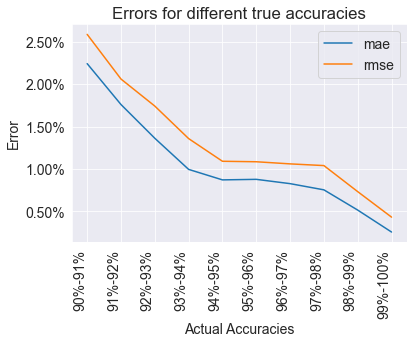

In [13]:
def get_error(y_preds, y_trues, a, b):
    y_preds = y_preds[(y_trues >= a) & (y_trues < b)]
    y_trues = y_trues[(y_trues >= a) & (y_trues < b)]

    return np.abs(y_preds - y_trues).mean(), ((y_preds - y_trues) ** 2).mean() ** 0.5


errors = []
bounds = np.linspace(0.9, 1, 11)
for a, b in zip(bounds[:-1], bounds[1:]):
    mae, rmse = get_error(y_preds, y_trues, a, b)
    errors.append([f"{a:.0%}-{b:.0%}", mae, rmse])

df_errors = pd.DataFrame(errors, columns=['bounds', 'mae', 'rmse'])
sns.lineplot(data=df_errors, x='bounds', y='mae', label='mae')
sns.lineplot(data=df_errors, x='bounds', y='rmse', label='rmse')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.title("Errors for different true accuracies")
plt.xlabel("Actual Accuracies")
plt.ylabel("Error")
_ = plt.xticks(rotation=90, ha='right')

With domain expert input, it's logical. Higher accuracies are difficult to improve, thus even small deviations can imply large skill gaps.
Vice versa.